In this notebook we will use the nn class **Sequential** to model a CNN

We will use the single target network

# Import

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm

In [2]:
import load_script

In [3]:
%load_ext autoreload
%autoreload 2

# Loading the dataset

In [4]:
train_dataset,target=load_script.load_dataset(train=True)

In [5]:
test_dataset,test_target=load_script.load_dataset(train=False)

In [6]:
target=target.long()
test_target=test_target.long()

# Added modules

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [8]:
class Tensor4D(nn.Module):
    def forward(self,input):
        return input.view(input.shape[0],1,*input.shape[1:])

In [9]:
class Tensor3D(nn.Module):
    def forward(self,input):
        return input.view(input.shape[0],input.shape[1],-1)

# Normalization

In [10]:
train_dataset.mean(0)

Variable containing:
 7.3101e+01  7.3109e+01  7.2001e+01  ...   6.4324e+01  6.5037e+01  6.5048e+01
 5.0706e+00  5.9728e+00  4.1829e+00  ...  -3.1212e+00 -2.7500e+00 -2.3117e+00
 5.3022e+01  5.3706e+01  5.2293e+01  ...   4.5319e+01  4.5553e+01  4.6292e+01
                ...                   ⋱                   ...                
 1.3597e+01  1.3734e+01  1.3298e+01  ...   1.0306e+01  1.0556e+01  1.0504e+01
 2.3973e+01  2.3983e+01  2.2980e+01  ...   2.2531e+01  2.2226e+01  2.2265e+01
 9.5851e+00  9.5892e+00  8.4953e+00  ...   8.9079e+00  9.0392e+00  8.8203e+00
[torch.FloatTensor of size 28x50]

In [11]:
train_dataset.shape

torch.Size([316, 28, 50])

In [12]:
mean=train_dataset.mean(0).view(1,28,-1)
std=train_dataset.std(0).view(1,28,-1)

In [13]:
train_dataset=(train_dataset-mean)/std
test_dataset=(test_dataset-mean)/std

# Defining the network

### Simple Network

In [14]:
class MyConv1D:
    def __init__(self,input_channels,output_channels,kernel,dropout_rate=0.8,batch_norm=True):
        self.conv=nn.Conv1d(input_channels,output_channels,kernel)
        self.relu=nn.ReLU()
        self.batch_norm=nn.BatchNorm1d(output_channels)
        self.dropout=nn.Dropout(dropout_rate)
        if batch_norm:
            self._layers=[self.conv,self.relu,self.batch_norm,self.dropout]
        else:
            self._layers=[self.conv,self.relu,self.batch_norm,self.dropout]
    
    @property
    def layers(self):
        return self._layers

In [15]:
class ThreeLayersParams(nn.Module):
    
    num_my_conv_layers=3
    num_linear_layers=2
    
    def __init__(self,params):
        super(ThreeLayersParams,self).__init__()
        
        self.params=params
        
        layers=[]
        for i in range(self.num_my_conv_layers): 
            layers+=MyConv1D(*self.params[i]).layers
        
        layers.append(Flatten())
        a=[*self.params[self.num_my_conv_layers]]
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers]))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers+1]))
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x

# Training

In [16]:
class LayerParams:
    def __init__(self,*args):
        self._params=[*args]
        
    def __str__(self):
        return str(self._params)
    
    def __repr__(self):
        return str(self)
    
    def __getitem__(self,key):
        return self._params[key]

In [17]:
class LayersParams:
    
    def __init__(self,*args):
        self.params=[*args]
        
    def __getitem__(self,key):
        return self.params[key]

In [18]:
class TrainParams:
    def __init__(self,mini_batch_size=79,
                 max_epoch=1000,
                 weights_initialization=0.02,
                 randomize_training_dataset=True):
        self._mini_batch_size=mini_batch_size
        self._max_epoch=max_epoch
        self._weights_initialization=weights_initialization
        self._randomize_training_dataset=randomize_training_dataset
        
    def params(self):
        return [self._mini_batch_size,self._max_epoch,self._max_epoch,self._randomize_training_dataset]
    
    @property
    def mini_batch_size(self):
        return self._mini_batch_size
    @property
    def max_epoch(self):
        return self._max_epoch
    @property
    def weights_initialization(self):
        return self._weights_initialization
    @property
    def randomize_training_dataset(self):
        return self._randomize_training_dataset

In [19]:
class NetworkParams:
    def __init__(self,conv_filters=False,conv_kernels=3,dropout_rate=0.8,batch_norm=True,linear_filters=False):
        self._conv_filters=conv_filters
        self._conv_kernels=conv_kernels
        self._dropout_rate=dropout_rate
        self._batch_norm=batch_norm
        self._linear_filters=linear_filters
        
    def params(self):
        return [self._conv_filters,self._conv_kernels,self._dropout_rate,self._batch_norm,self._linear_filters]

In [20]:
class OptimizerParams:
    def __init__(self,learning_rate=0.001,
                 weight_decay=0):
        self._learning_rate=learning_rate
        self._weight_decay=weight_decay
        
    def params(self):
        return {'lr':self._learning_rate,'weight_decay':self._weight_decay}
    
    @property
    def learning_rate(self):
        return self._learning_rate
    @property
    def weight_decay(self):
        return self._weight_decay

In [21]:
class Params:
    ''' Class that defines the parameters of a network evaluation.
    
    
    '''
    
    _input_shape=(28,50)
    
    def __init__(self,network_type,
                 optimizer_type,
                 criterion_type,
                 network_params=NetworkParams(),
                 optimizer_params=OptimizerParams(),
                 train_params=TrainParams(),
                 plot=True,
                 verbose=False):
        
        # Set up network
        self._network_type=network_type
        self._network_params=network_params
        self._layers_params=self.set_up_network_params(*self.network_params.params())        
        self._network=network_type(self._layers_params)

        # Set up optimizer
        self._optimizer_params=optimizer_params
        self._optimizer=optimizer_type(self.network.parameters(), **self.optimizer_params.params())

        # Set up criterion
        self._criterion=criterion_type()
        
        # Set up training parameters
        self._train_params=train_params
        
        # Set up visualization parameters
        self._plot=plot
        self._verbose=verbose
        
    def set_up_network_params(self,conv_filters,conv_kernels,dropout_rate,batch_norm,linear_filters):
        # We automatically create LayersParams based on the input given
        self._num_my_conv_layers=self._network_type.num_my_conv_layers
        self._num_linear_layers=self._network_type.num_linear_layers
        
        # Set up conv_filters
        self._conv_filters=[self._input_shape[0]]+\
                    self.add_params_sequence(self._num_my_conv_layers,conv_filters,self._input_shape[0])
        
        # Set up conv_kernel
        self._conv_kernels=self.add_params_sequence(self._num_my_conv_layers,conv_kernels,3)
        
        # Set up dropout
        self._dropout_rate=self.add_params_sequence(self._num_my_conv_layers,dropout_rate,0.2)
        
        # Set up batch norm
        self._batch_norm=self.add_params_sequence(self._num_my_conv_layers,batch_norm,True)
        
        
        # Set up linar_layers
        self._linear_layer_start_filters=int(self._conv_filters[-1]*(self._input_shape[1]-
                                        np.sum([(x-1) for x in self._conv_kernels])))
        print(self._conv_filters[-1])
        self._linear_filters=[self._linear_layer_start_filters]+\
                        self.add_params_sequence(self._num_linear_layers,linear_filters,False)
        
        self._layer_params_list=[]
        for i in range(self._num_my_conv_layers):
            self._layer_params_list.append(LayerParams(*self._conv_filters[i:i+2],self._conv_kernels[i],self._dropout_rate[i]))
        for i in range(self._num_linear_layers):
            self._layer_params_list.append(LayerParams(*self._linear_filters[i:i+2]))
        
        _layer_params=LayerParams(*self._layer_params_list)
        return _layer_params
        
    def add_params_sequence(self,num_layers,params,default_value):
        if not params:
            params=[default_value]*num_layers
        try:
            if len(params)!=num_layers:
                params=[default_value]*num_layers
        except:
            params=[params]*num_layers
            
        return params
    
    
    @property
    def network(self):
        return self._network
    @property
    def optimizer(self):
        return self._optimizer
    @property
    def criterion(self):
        return self._criterion
    @property
    def network_params(self):
        return self._network_params
    @property
    def optimizer_params(self):
        return self._optimizer_params
    @property
    def train_params(self):
        return self._train_params
    @property
    def plot(self):
        return self._plot
    @property
    def verbose(self):
        return self._verbose

In [22]:
class Train:
    
    def __init__(self):
        pass
        
    def __call__(self,params,repetitions=5):
        epochs=[]
        errors_max=[]
        errors_mean=[]
        for i in range(repetitions):
            for param in params.network.parameters():
                param.data.normal_(0, params.train_params.weights_initialization)
            print('Repetition',i)
            epoch,error_max,error_mean=self.train_test_network(params)
            epochs.append(epoch)
            errors_max.append(error_max)
            errors_mean.append(error_mean)
        
        return epochs,errors_max,errors_mean
    
    
    def train_test_network(self,params):
    
        errors_train=[]
        errors_test=[]
        
        
        for epoch in tqdm(range(params.train_params.max_epoch)):
            
            total_loss,output_train,error_train=self.train_epoch(params)
            output_test,error_test=self.test_epoch(params)
        
        
            errors_train.append(error_train)
            errors_test.append(error_test)
            
            if epoch%10==0 and params.verbose:
                print('Epoch:',epoch,'Loss:',total_loss,'Correct:',str(error_train*100)[:5]+"%",
                     'Correct test:',str(error_test*100)[:5]+"%")
                
        if params.plot:
            
            print('Performance:',np.mean(errors_test[params.train_params.max_epoch-100:]))
            plt.plot(list(range(epoch+1)),errors_train,label='Errors train')
            plt.plot(list(range(epoch+1)) ,errors_test,label='Errors test')
            
            plt.legend()
            plt.show()
                 
        return epoch,np.max(errors_test),np.mean(errors_test[300:])
    
    
    
    def train_epoch(self,params):
        
        # Set training True
        params.network.train(True)
        
        # Randomize training dataset
        if params.train_params.randomize_training_dataset:
            random_permutation=torch.randperm(train_dataset.shape[0])
        else:
            random_permutation=torch.arange(train_dataset.shape[0])

        train_dataset_shuffled=train_dataset[random_permutation]
        target_shuffled=target[random_permutation]
        
        
        # Iterate on the dataset
        total_loss=0
        output_target=torch.zeros(target_shuffled.shape[0])
        for b in range(0,train_dataset_shuffled.shape[0],params.train_params.mini_batch_size):

            train_element=train_dataset_shuffled.narrow(0,b,params.train_params.mini_batch_size)
            target_element=target_shuffled.narrow(0,b,params.train_params.mini_batch_size)

            params.optimizer.zero_grad()

            out=params.network(train_element)
            output_target[b:b+params.train_params.mini_batch_size]=(out[:,1]>out[:,0]).data

            loss=params.criterion(out,target_element)
            loss.backward()
            params.optimizer.step()
            total_loss+=loss.data[0]
            
        error_train=np.sum(list(output_target.long()==target_shuffled.data))/target.shape[0]    
        
        return total_loss,output_target,error_train
    
    def test_epoch(self,params):
        params.network.train(False)
        output_test=torch.zeros(test_target.shape[0])
        out=params.network.forward(test_dataset)
        output_test=(out[:,1]>out[:,0]).data.long()
        error_test=np.sum(list(output_test==test_target.data))/test_target.shape[0]
        
        return output_test,error_test

### Dropout - best=0.8

In [25]:
for i in tqdm(range(1000)):
    a=np.random.rand(3000,3000)
#     c=a.dot(a)


  4%|▍         | 39/1000 [00:04<01:42,  9.37it/s]

KeyboardInterrupt: 

In [ ]:
np.

In [23]:
for dropout_rate in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    net_type=ThreeLayersParams
    optimizer_type=optim.Adam
    criterion_type=nn.CrossEntropyLoss
    network_params=NetworkParams(linear_filters=[200,2],dropout_rate=dropout_rate)
    optimizer_params=OptimizerParams()
    train_params=TrainParams(max_epoch=400)


    params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
                  optimizer_params=optimizer_params,train_params=train_params,)

    train=Train()
    epochs,errors_max,errors_mean=train(params)
    print('Dropout rate:',dropout_rate)
    print(errors_max,errors_mean)

  0%|          | 0/400 [00:00<?, ?it/s]

28
Repetition 0


 16%|█▋        | 66/400 [00:06<00:33,  9.85it/s]


KeyboardInterrupt: 

### Weight decay - acceptable up to 0.001. We can leave it to 0

  0%|          | 1/400 [00:00<00:43,  9.11it/s]

28
Repetition 0


100%|██████████| 400/400 [00:41<00:00,  9.65it/s]


Performance: 0.8033


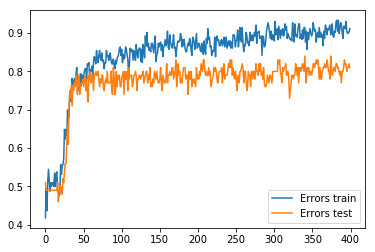

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:41<00:00,  9.65it/s]


Performance: 0.7926


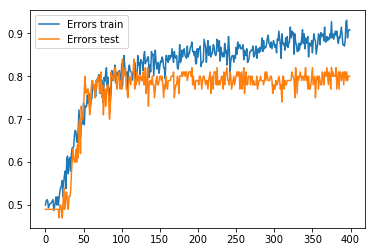

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 400/400 [00:41<00:00,  9.71it/s]


Performance: 0.793


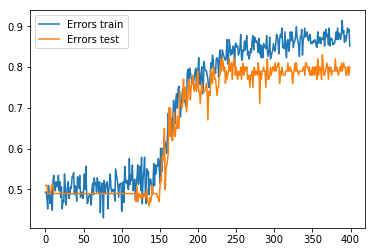

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 400/400 [00:40<00:00,  9.85it/s]


Performance: 0.7878


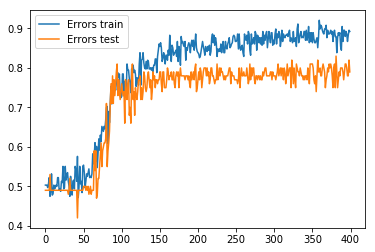

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 400/400 [00:40<00:00,  9.80it/s]


Performance: 0.7853


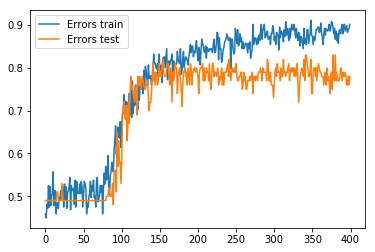

  0%|          | 0/400 [00:00<?, ?it/s]

Weight decay: 0.001
[0.83999999999999997, 0.83999999999999997, 0.82999999999999996, 0.82999999999999996, 0.82999999999999996] [0.80330000000000013, 0.79260000000000008, 0.79299999999999993, 0.78780000000000006, 0.7853]
28
Repetition 0


100%|██████████| 400/400 [00:44<00:00,  9.03it/s]


Performance: 0.7963


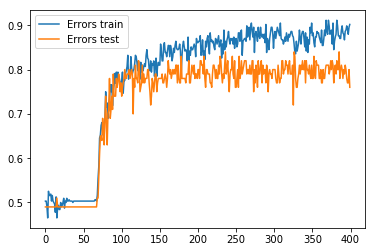

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]


Performance: 0.7989


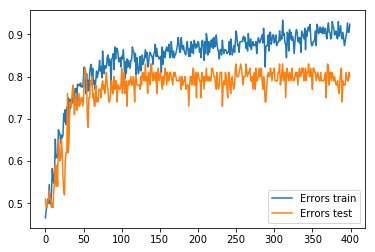

  0%|          | 1/400 [00:00<00:40,  9.76it/s]

Repetition 2


100%|██████████| 400/400 [00:42<00:00,  9.49it/s]


Performance: 0.7887


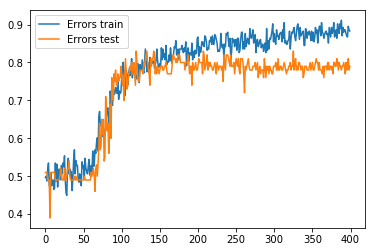

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 400/400 [00:42<00:00,  9.32it/s]


Performance: 0.5842


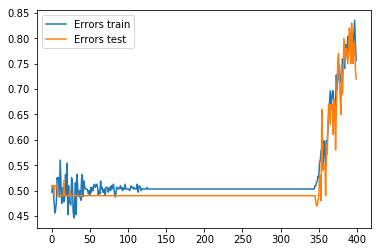

  0%|          | 1/400 [00:00<00:43,  9.26it/s]

Repetition 4


100%|██████████| 400/400 [00:43<00:00,  9.28it/s]


Performance: 0.7901


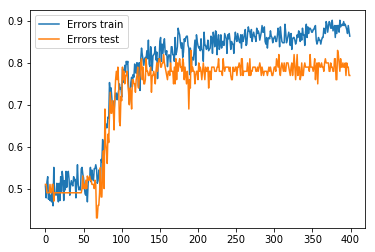

  0%|          | 0/400 [00:00<?, ?it/s]

Weight decay: 0.003
[0.83999999999999997, 0.82999999999999996, 0.82999999999999996, 0.82999999999999996, 0.82999999999999996] [0.79630000000000001, 0.79890000000000005, 0.78870000000000018, 0.58420000000000005, 0.79010000000000002]
28
Repetition 0


100%|██████████| 400/400 [00:40<00:00,  9.88it/s]


Performance: 0.7923


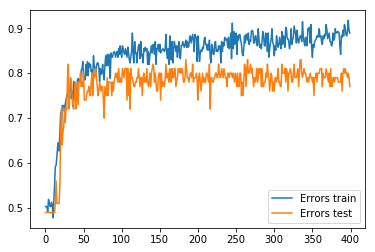

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:42<00:00,  9.41it/s]


Performance: 0.49


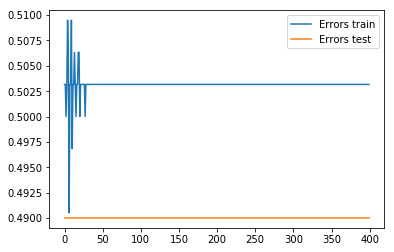

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 400/400 [00:41<00:00,  9.68it/s]


Performance: 0.7988


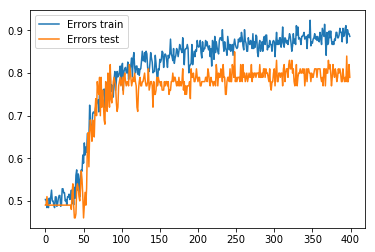

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 400/400 [00:43<00:00,  9.21it/s]

Performance: 0.7906


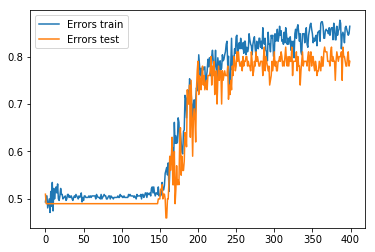

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 400/400 [00:44<00:00,  9.01it/s]


Performance: 0.49


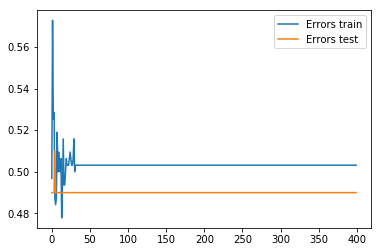

Weight decay: 0.006
[0.82999999999999996, 0.48999999999999999, 0.84999999999999998, 0.81999999999999995, 0.51000000000000001] [0.7923, 0.49000000000000021, 0.79880000000000007, 0.79060000000000019, 0.49000000000000021]
28


  0%|          | 1/400 [00:00<00:41,  9.51it/s]

Repetition 0


100%|██████████| 400/400 [00:40<00:00,  9.86it/s]


Performance: 0.7997


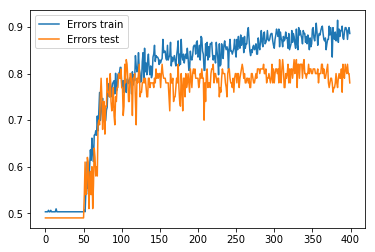

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:45<00:00,  8.75it/s]

Performance: 0.49


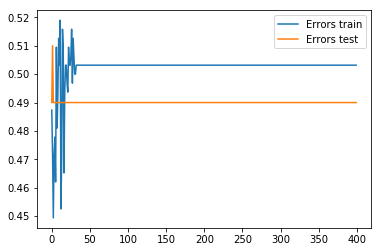

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 400/400 [00:51<00:00,  7.71it/s]

Performance: 0.49


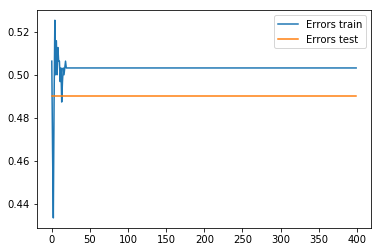

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 400/400 [00:55<00:00,  7.20it/s]

Performance: 0.49


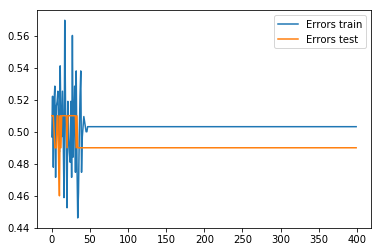

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 400/400 [01:16<00:00,  5.20it/s]

Performance: 0.49


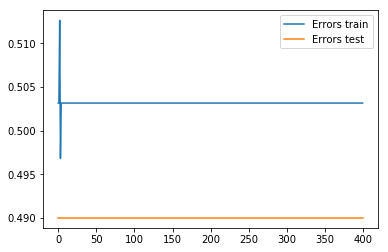

Weight decay: 0.01
[0.82999999999999996, 0.51000000000000001, 0.48999999999999999, 0.51000000000000001, 0.48999999999999999] [0.79969999999999986, 0.49000000000000021, 0.49000000000000021, 0.49000000000000021, 0.49000000000000021]


In [59]:
dropout_rate=0.8
for weight_decay in [0.001,0.003,0.006,0.01]:
    net_type=ThreeLayersParams
    optimizer_type=optim.Adam
    criterion_type=nn.CrossEntropyLoss
    network_params=NetworkParams(linear_filters=[200,2],dropout_rate=dropout_rate)
    optimizer_params=OptimizerParams(weight_decay=weight_decay)
    train_params=TrainParams(max_epoch=400)


    params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
                  optimizer_params=optimizer_params,train_params=train_params)

    train=Train()
    epochs,errors_max,errors_mean=train(params)
    print('Weight decay:',weight_decay)
    print(errors_max,errors_mean)

### No batch norm

  0%|          | 1/400 [00:00<00:41,  9.61it/s]

28
Repetition 0


100%|██████████| 400/400 [00:39<00:00, 10.18it/s]


Performance: 0.7366


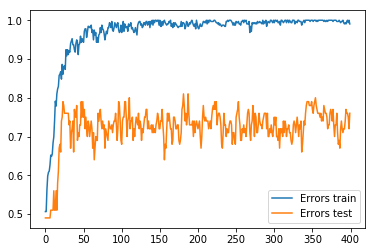

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:39<00:00, 10.20it/s]


Performance: 0.7483


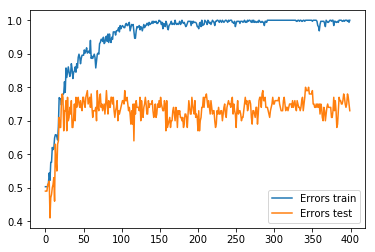

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 400/400 [00:38<00:00, 10.33it/s]


Performance: 0.7266


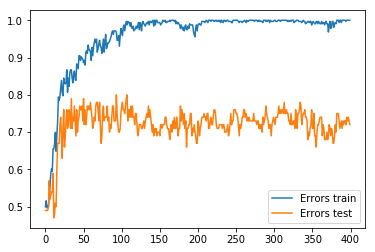

  0%|          | 1/400 [00:00<00:40,  9.82it/s]

Repetition 3


100%|██████████| 400/400 [00:38<00:00, 10.26it/s]


Performance: 0.7668


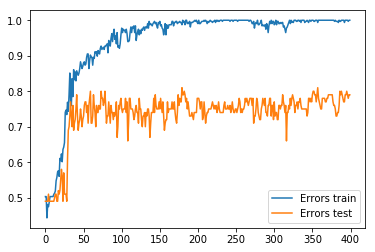

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 400/400 [00:39<00:00, 10.25it/s]


Performance: 0.7127


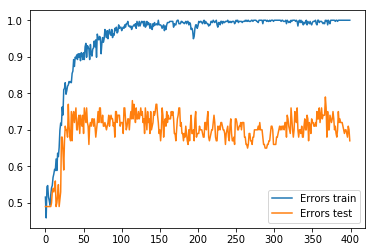

  0%|          | 0/400 [00:00<?, ?it/s]

Dropout rate: 0
[0.81000000000000005, 0.80000000000000004, 0.80000000000000004, 0.81000000000000005, 0.79000000000000004] [0.73660000000000014, 0.74829999999999997, 0.72659999999999991, 0.76680000000000026, 0.7127]
28
Repetition 0


100%|██████████| 400/400 [00:39<00:00, 10.17it/s]


Performance: 0.7648


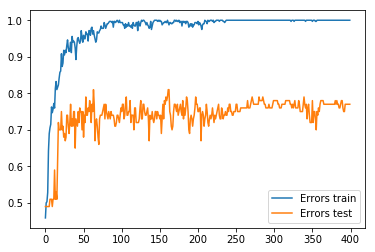

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:39<00:00, 10.21it/s]


Performance: 0.7415


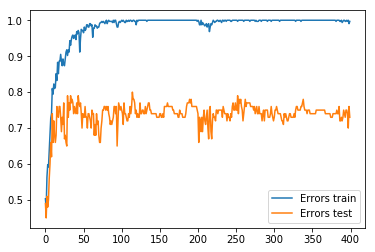

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 400/400 [00:38<00:00, 10.26it/s]


Performance: 0.6997


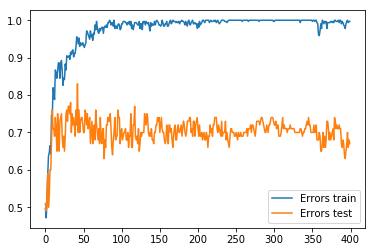

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 400/400 [00:38<00:00, 10.28it/s]


Performance: 0.7675


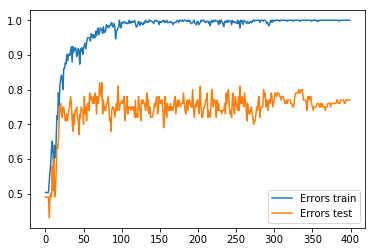

  0%|          | 2/400 [00:00<00:38, 10.36it/s]

Repetition 4


100%|██████████| 400/400 [00:38<00:00, 10.27it/s]


Performance: 0.7199


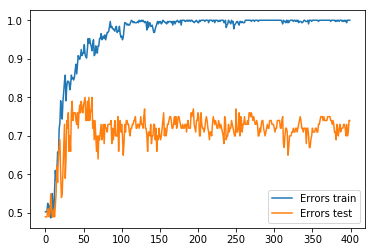

Dropout rate: 0.1
[0.81000000000000005, 0.80000000000000004, 0.82999999999999996, 0.81999999999999995, 0.80000000000000004] [0.7647999999999997, 0.74150000000000005, 0.69969999999999999, 0.76749999999999974, 0.71989999999999976]
28


  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 0


100%|██████████| 400/400 [00:39<00:00, 10.22it/s]


Performance: 0.7251


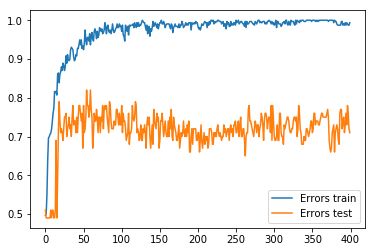

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:38<00:00, 10.30it/s]


Performance: 0.7357


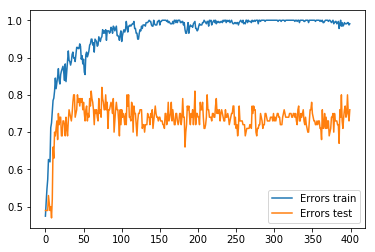

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 400/400 [00:38<00:00, 10.31it/s]


Performance: 0.7375


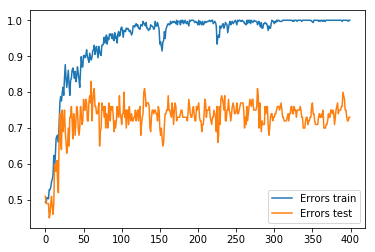

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 400/400 [00:41<00:00,  9.70it/s]


Performance: 0.7238


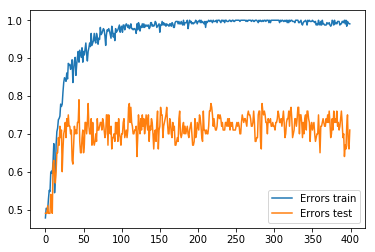

  0%|          | 1/400 [00:00<00:57,  6.93it/s]

Repetition 4


100%|██████████| 400/400 [00:45<00:00,  8.77it/s]


Performance: 0.7464


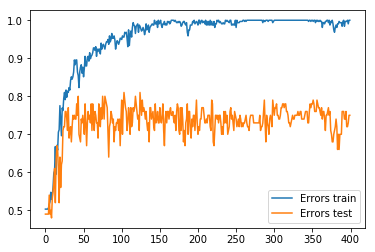

  0%|          | 1/400 [00:00<00:40,  9.90it/s]

Dropout rate: 0.2
[0.81999999999999995, 0.81999999999999995, 0.82999999999999996, 0.79000000000000004, 0.81000000000000005] [0.72510000000000008, 0.73570000000000002, 0.73750000000000004, 0.7238, 0.74639999999999995]
28
Repetition 0


100%|██████████| 400/400 [00:38<00:00, 10.30it/s]


Performance: 0.7408


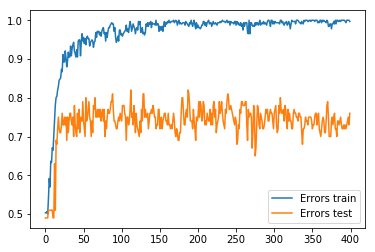

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:41<00:00,  9.55it/s]


Performance: 0.7506


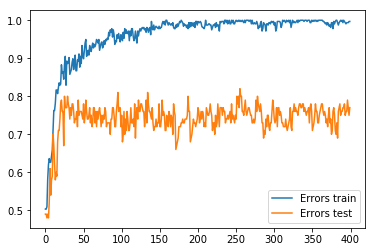

  0%|          | 1/400 [00:00<00:50,  7.83it/s]

Repetition 2


100%|██████████| 400/400 [00:39<00:00, 10.17it/s]

Performance: 0.7097


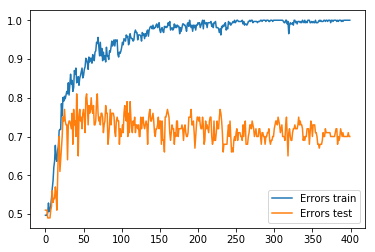

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 400/400 [00:38<00:00, 10.33it/s]


Performance: 0.7255


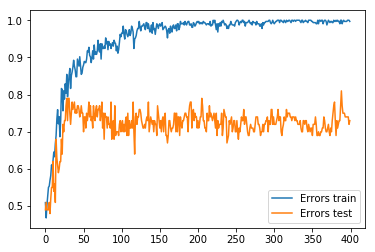

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 400/400 [00:39<00:00, 10.25it/s]

Performance: 0.747


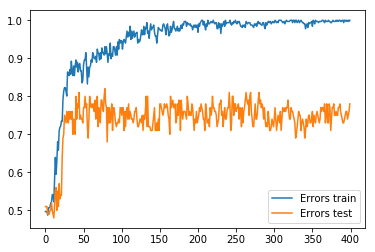

  0%|          | 0/400 [00:00<?, ?it/s]

Dropout rate: 0.3
[0.81999999999999995, 0.81999999999999995, 0.81000000000000005, 0.81000000000000005, 0.81999999999999995] [0.74080000000000001, 0.75059999999999993, 0.7097, 0.72549999999999992, 0.74700000000000022]
28
Repetition 0


100%|██████████| 400/400 [00:38<00:00, 10.38it/s]


Performance: 0.719


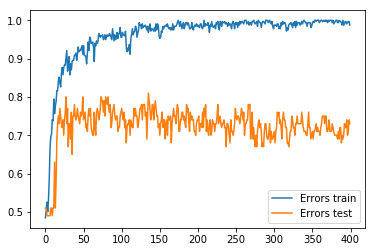

  0%|          | 2/400 [00:00<00:38, 10.29it/s]

Repetition 1


100%|██████████| 400/400 [00:39<00:00, 10.22it/s]


Performance: 0.7534


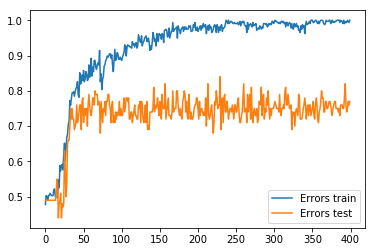

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 400/400 [00:38<00:00, 10.34it/s]

Performance: 0.7292


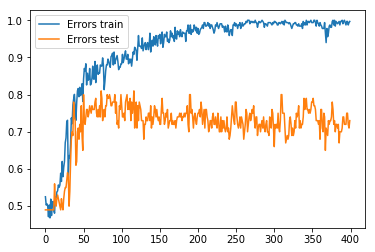

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 400/400 [00:38<00:00, 10.26it/s]


Performance: 0.7267


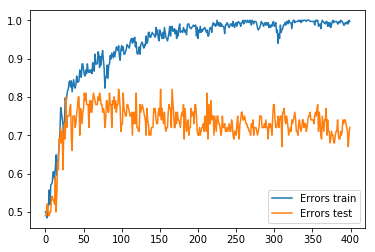

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 400/400 [00:38<00:00, 10.33it/s]


Performance: 0.7373


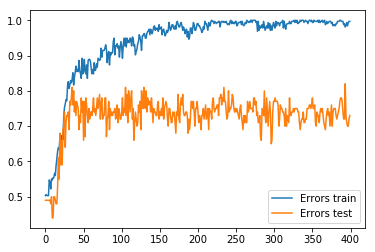

  0%|          | 0/400 [00:00<?, ?it/s]

Dropout rate: 0.4
[0.81000000000000005, 0.83999999999999997, 0.81000000000000005, 0.81999999999999995, 0.81999999999999995] [0.71899999999999986, 0.75339999999999985, 0.72920000000000007, 0.72670000000000001, 0.73730000000000007]
28
Repetition 0


100%|██████████| 400/400 [00:40<00:00,  9.96it/s]


Performance: 0.7412


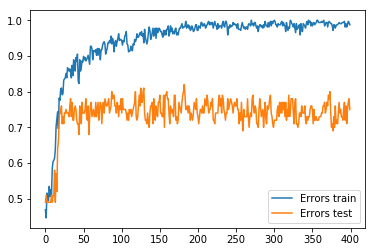

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:39<00:00, 10.02it/s]


Performance: 0.7305


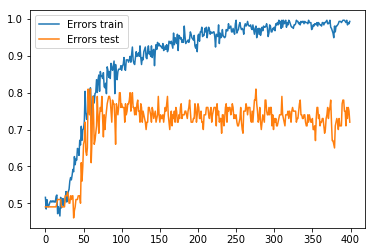

  0%|          | 2/400 [00:00<00:37, 10.55it/s]

Repetition 2


100%|██████████| 400/400 [00:41<00:00,  9.75it/s]


Performance: 0.7413


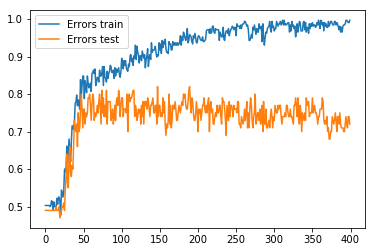

  0%|          | 1/400 [00:00<01:02,  6.40it/s]

Repetition 3


100%|██████████| 400/400 [00:40<00:00,  9.79it/s]


Performance: 0.7358


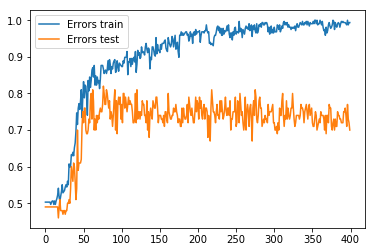

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 400/400 [00:40<00:00,  9.94it/s]


Performance: 0.7388


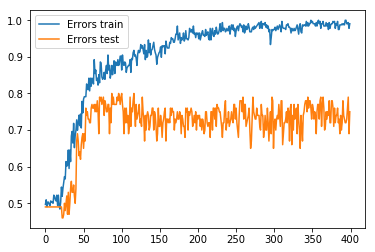

  0%|          | 0/400 [00:00<?, ?it/s]

Dropout rate: 0.5
[0.81999999999999995, 0.81000000000000005, 0.81999999999999995, 0.81999999999999995, 0.80000000000000004] [0.74119999999999986, 0.73050000000000015, 0.74129999999999985, 0.73580000000000001, 0.73880000000000012]
28
Repetition 0


100%|██████████| 400/400 [00:40<00:00,  9.96it/s]


Performance: 0.7479


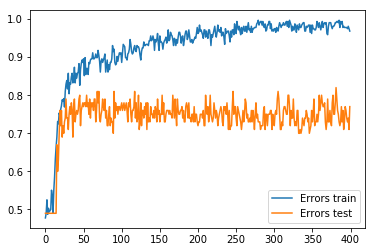

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:39<00:00, 10.22it/s]


Performance: 0.7345


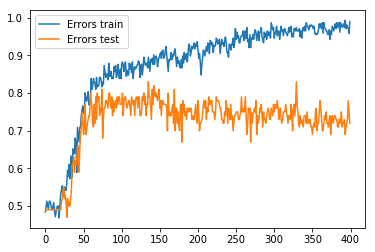

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 400/400 [00:42<00:00,  9.47it/s]


Performance: 0.7347


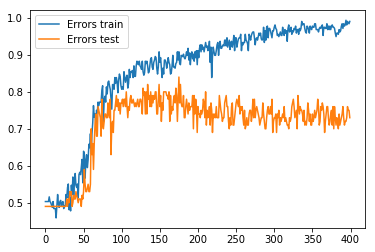

  0%|          | 1/400 [00:00<00:42,  9.40it/s]

Repetition 3


100%|██████████| 400/400 [00:45<00:00,  8.88it/s]


Performance: 0.769


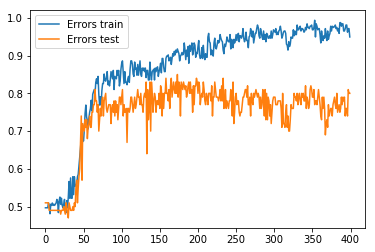

  0%|          | 1/400 [00:00<00:46,  8.53it/s]

Repetition 4


100%|██████████| 400/400 [00:42<00:00,  9.42it/s]


Performance: 0.7575


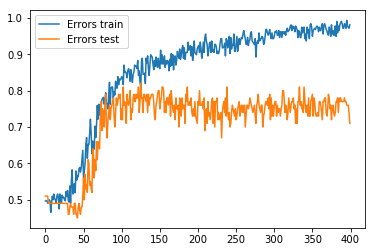

  0%|          | 1/400 [00:00<00:41,  9.51it/s]

Dropout rate: 0.6
[0.81999999999999995, 0.82999999999999996, 0.83999999999999997, 0.84999999999999998, 0.81999999999999995] [0.7478999999999999, 0.73450000000000015, 0.73470000000000002, 0.76899999999999991, 0.75749999999999995]
28
Repetition 0


100%|██████████| 400/400 [00:43<00:00,  9.18it/s]

Performance: 0.7332


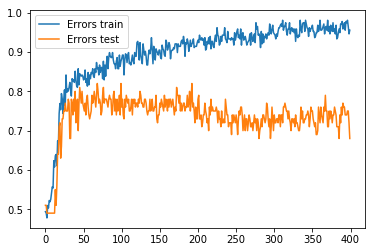

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:42<00:00,  9.32it/s]


Performance: 0.7848


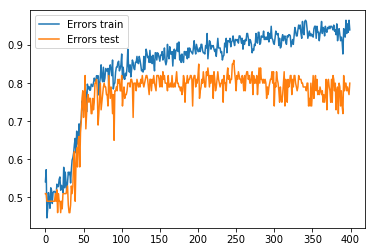

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 400/400 [00:41<00:00,  9.61it/s]


Performance: 0.7657


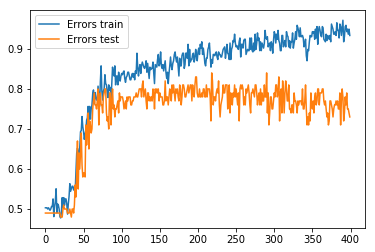

  0%|          | 1/400 [00:00<00:49,  8.08it/s]

Repetition 3


100%|██████████| 400/400 [00:44<00:00,  8.98it/s]

Performance: 0.7884


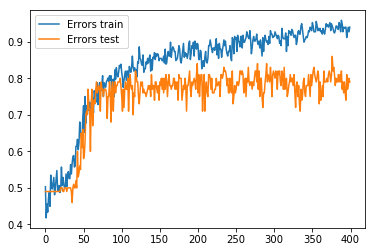

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 400/400 [00:40<00:00,  9.99it/s]


Performance: 0.778


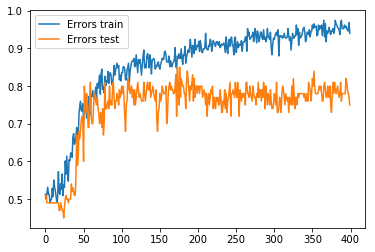

  0%|          | 0/400 [00:00<?, ?it/s]

Dropout rate: 0.7
[0.81999999999999995, 0.85999999999999999, 0.83999999999999997, 0.85999999999999999, 0.84999999999999998] [0.73319999999999996, 0.78480000000000005, 0.76569999999999994, 0.78839999999999999, 0.77800000000000002]
28
Repetition 0


100%|██████████| 400/400 [00:39<00:00, 10.20it/s]


Performance: 0.8041


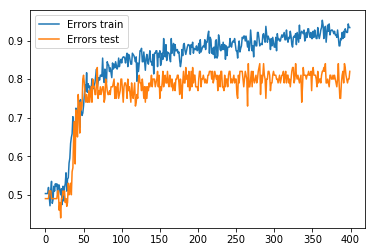

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:39<00:00, 10.11it/s]


Performance: 0.8009


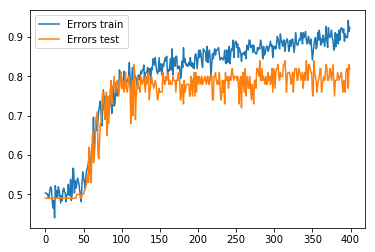

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 400/400 [00:45<00:00,  8.74it/s]


Performance: 0.7896


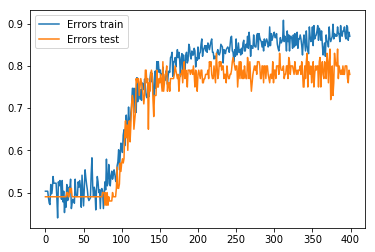

  0%|          | 1/400 [00:00<00:42,  9.43it/s]

Repetition 3


100%|██████████| 400/400 [00:42<00:00,  9.46it/s]


Performance: 0.7958


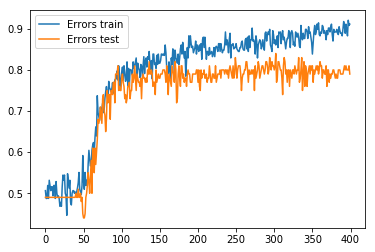

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 400/400 [00:41<00:00,  9.74it/s]


Performance: 0.7596


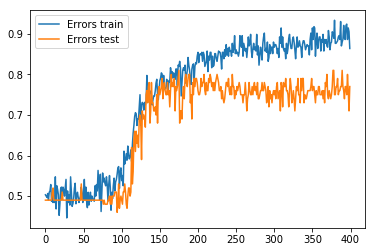

Dropout rate: 0.8
[0.83999999999999997, 0.83999999999999997, 0.83999999999999997, 0.83999999999999997, 0.81000000000000005] [0.80409999999999993, 0.80089999999999972, 0.78960000000000008, 0.79579999999999995, 0.75959999999999983]
28


  0%|          | 1/400 [00:00<00:44,  8.97it/s]

Repetition 0


100%|██████████| 400/400 [00:41<00:00,  9.60it/s]


Performance: 0.7822


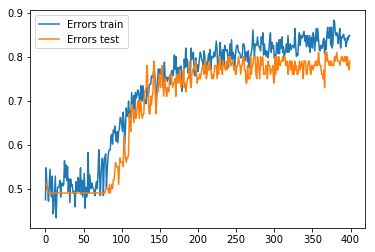

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:43<00:00,  9.23it/s]


Performance: 0.7978


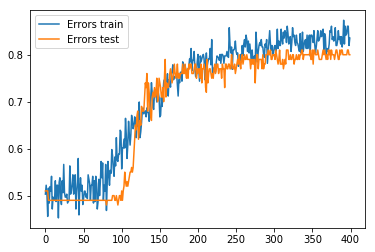

  0%|          | 1/400 [00:00<01:06,  5.98it/s]

Repetition 2


100%|██████████| 400/400 [00:44<00:00,  8.97it/s]

Performance: 0.7754


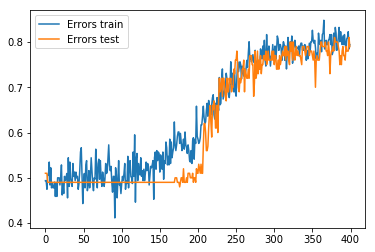

  0%|          | 1/400 [00:00<00:40,  9.85it/s]

Repetition 3


100%|██████████| 400/400 [00:42<00:00,  9.36it/s]


Performance: 0.7852


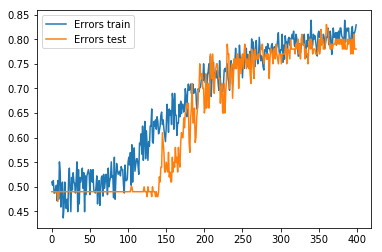

  0%|          | 2/400 [00:00<00:39, 10.09it/s]

Repetition 4


100%|██████████| 400/400 [00:39<00:00, 10.05it/s]


Performance: 0.7729


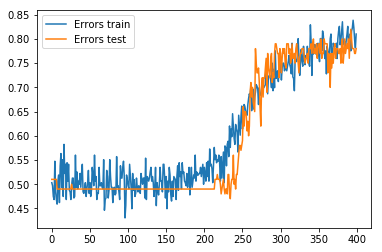

Dropout rate: 0.9
[0.81000000000000005, 0.81000000000000005, 0.81000000000000005, 0.82999999999999996, 0.81999999999999995] [0.78220000000000012, 0.79780000000000006, 0.77540000000000009, 0.78520000000000012, 0.77289999999999992]


In [61]:
for dropout_rate in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    net_type=ThreeLayersParams
    optimizer_type=optim.Adam
    criterion_type=nn.CrossEntropyLoss
    network_params=NetworkParams(linear_filters=[200,2],dropout_rate=dropout_rate,batch_norm=False)
    optimizer_params=OptimizerParams()
    train_params=TrainParams(max_epoch=400)


    params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
                  optimizer_params=optimizer_params,train_params=train_params,)

    train=Train()
    epochs,errors_max,errors_mean=train(params)
    print('Dropout rate:',dropout_rate)
    print(errors_max,errors_mean)

### Learning rate - best 0.001

  0%|          | 1/1000 [00:00<01:55,  8.63it/s]

28
Repetition 0


100%|██████████| 1000/1000 [01:38<00:00, 10.14it/s]


Performance: 0.4875


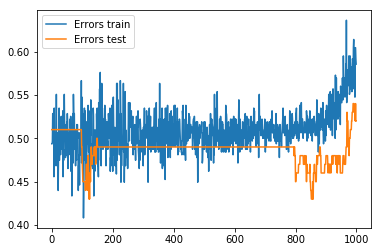

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 1000/1000 [01:38<00:00, 10.19it/s]


Performance: 0.725


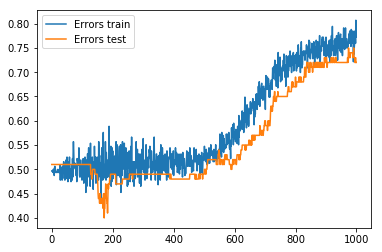

Repetition 2


100%|██████████| 1000/1000 [01:38<00:00, 10.18it/s]

Performance: 0.49


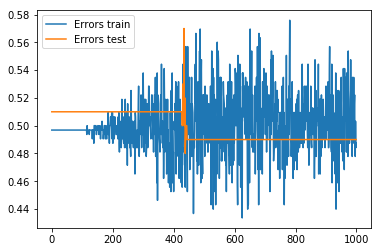

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 1000/1000 [01:38<00:00, 10.18it/s]


Performance: 0.4945


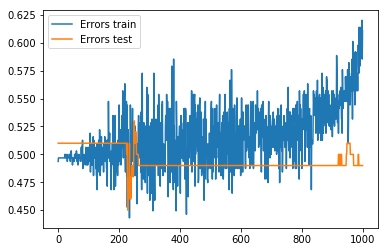

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 1000/1000 [01:38<00:00, 10.16it/s]


Performance: 0.49


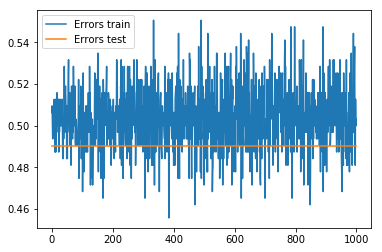

  0%|          | 0/1000 [00:00<?, ?it/s]

Learning rate: 1e-05
[0.54000000000000004, 0.75, 0.56999999999999995, 0.53000000000000003, 0.48999999999999999] [0.48597142857142867, 0.58751428571428566, 0.49415714285714296, 0.49064285714285727, 0.49000000000000016]
28
Repetition 0


100%|██████████| 1000/1000 [01:37<00:00, 10.28it/s]


Performance: 0.7821


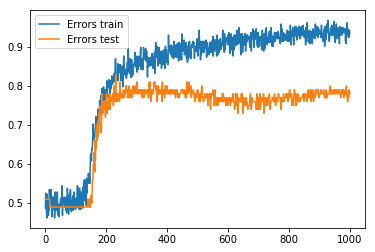

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 1000/1000 [01:37<00:00, 10.21it/s]


Performance: 0.7909


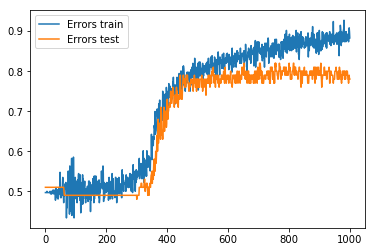

  0%|          | 1/1000 [00:00<01:41,  9.82it/s]

Repetition 2


100%|██████████| 1000/1000 [01:38<00:00, 10.12it/s]


Performance: 0.7917


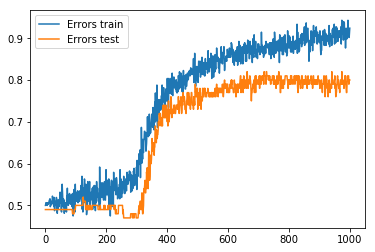

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 1000/1000 [01:42<00:00,  9.76it/s]


Performance: 0.7584


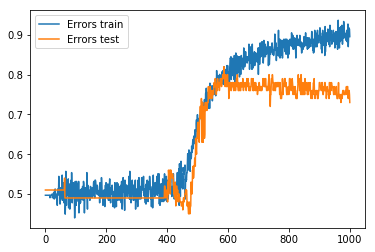

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 1000/1000 [01:47<00:00,  9.32it/s]


Performance: 0.761


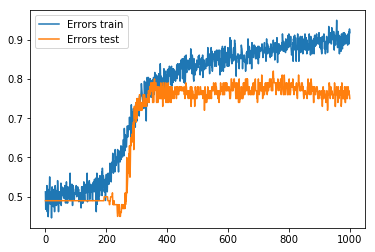

  0%|          | 0/1000 [00:00<?, ?it/s]

Learning rate: 0.0001
[0.82999999999999996, 0.81999999999999995, 0.81999999999999995, 0.81999999999999995, 0.81999999999999995] [0.77441428571428572, 0.75244285714285719, 0.75735714285714284, 0.68825714285714301, 0.76842857142857157]
28
Repetition 0


100%|██████████| 1000/1000 [01:42<00:00,  9.76it/s]


Performance: 0.7917


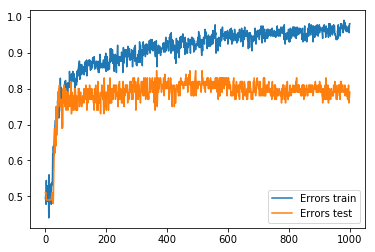

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 1000/1000 [01:38<00:00, 10.18it/s]


Performance: 0.7797


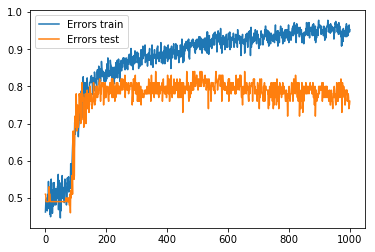

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 1000/1000 [01:39<00:00, 10.07it/s]


Performance: 0.7705


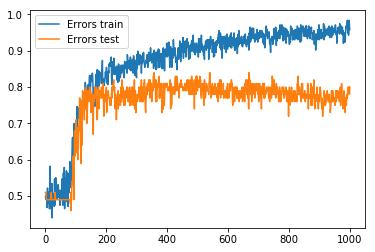

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 1000/1000 [01:39<00:00, 10.07it/s]

Performance: 0.7843


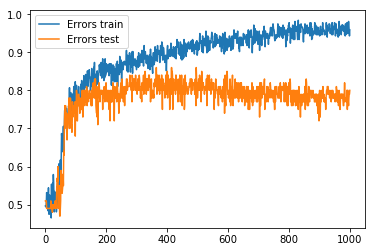

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 1000/1000 [01:37<00:00, 10.21it/s]


Performance: 0.7873


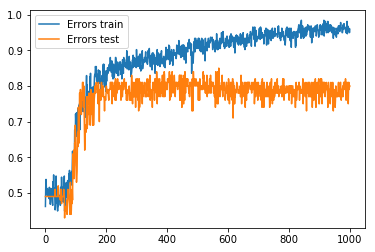

  0%|          | 0/1000 [00:00<?, ?it/s]

Learning rate: 0.001
[0.84999999999999998, 0.83999999999999997, 0.83999999999999997, 0.85999999999999999, 0.84999999999999998] [0.80004285714285728, 0.79132857142857138, 0.78667142857142869, 0.79718571428571428, 0.79158571428571434]
28
Repetition 0


100%|██████████| 1000/1000 [01:39<00:00, 10.04it/s]


Performance: 0.7759


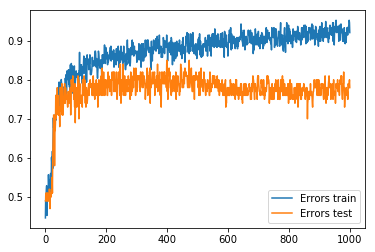

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 1000/1000 [01:46<00:00,  9.36it/s]


Performance: 0.7931


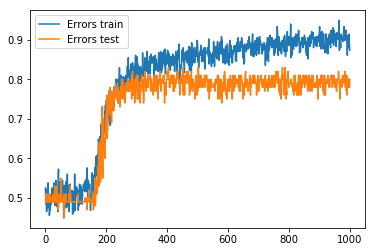

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 1000/1000 [02:20<00:00,  7.13it/s]


Performance: 0.4916


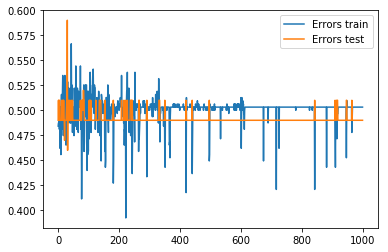

  0%|          | 1/1000 [00:00<01:54,  8.70it/s]

Repetition 3


100%|██████████| 1000/1000 [02:28<00:00,  6.73it/s]


Performance: 0.4904


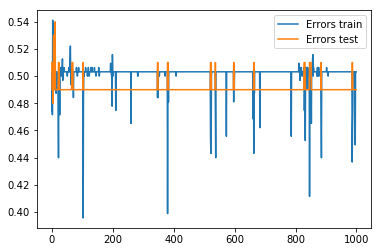

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 1000/1000 [02:27<00:00,  6.78it/s]


Performance: 0.49


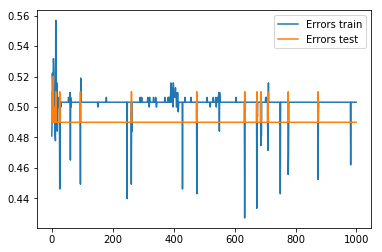

  0%|          | 0/1000 [00:00<?, ?it/s]

Learning rate: 0.01
[0.84999999999999998, 0.82999999999999996, 0.58999999999999997, 0.54000000000000004, 0.52000000000000002] [0.78192857142857142, 0.79097142857142866, 0.49045714285714304, 0.49074285714285726, 0.49031428571428592]
28
Repetition 0


100%|██████████| 1000/1000 [02:27<00:00,  6.78it/s]


Performance: 0.4984


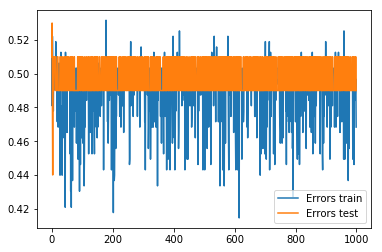

Repetition

  0%|          | 1/1000 [00:00<01:44,  9.57it/s]

 1


100%|██████████| 1000/1000 [02:25<00:00,  6.87it/s]


Performance: 0.4974


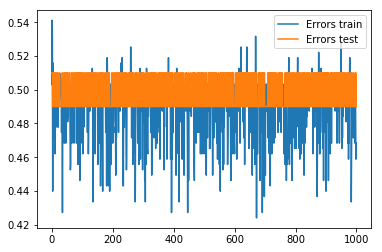

  0%|          | 1/1000 [00:00<01:47,  9.25it/s]

Repetition 2


100%|██████████| 1000/1000 [02:25<00:00,  6.87it/s]


Performance: 0.4988


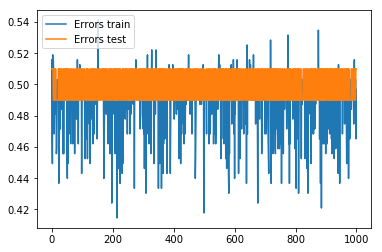

Repetition

  0%|          | 1/1000 [00:00<01:42,  9.76it/s]

 3


100%|██████████| 1000/1000 [02:21<00:00,  7.06it/s]


Performance: 0.4972


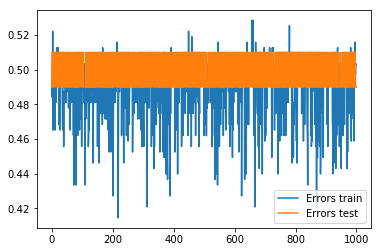

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 1000/1000 [02:16<00:00,  7.34it/s]


Performance: 0.497


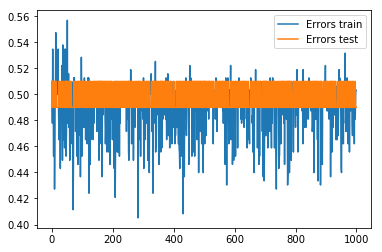

  0%|          | 0/1000 [00:00<?, ?it/s]

Learning rate: 0.1
[0.53000000000000003, 0.51000000000000001, 0.51000000000000001, 0.51000000000000001, 0.51000000000000001] [0.49791428571428564, 0.49774285714285726, 0.49802857142857143, 0.49814285714285722, 0.49794285714285713]
28
Repetition 0


100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s]


Performance: 0.4988


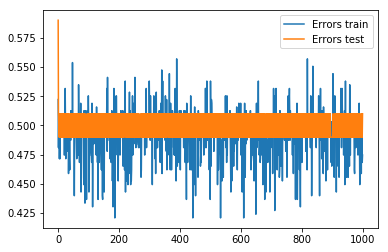

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 1000/1000 [02:33<00:00,  6.50it/s]


Performance: 0.4998


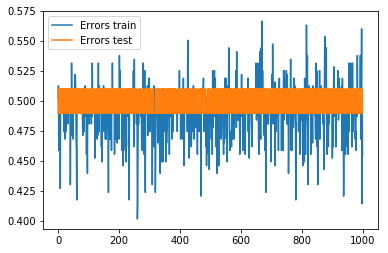

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 1000/1000 [02:35<00:00,  6.41it/s]


Performance: 0.4984


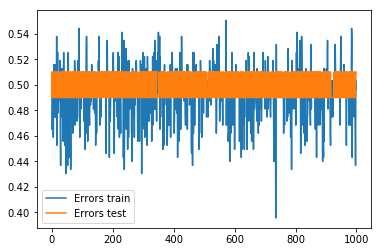

  0%|          | 1/1000 [00:00<01:47,  9.33it/s]

Repetition 3


100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]

Performance: 0.4996


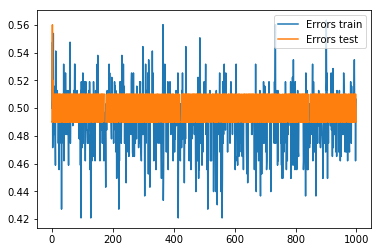

  0%|          | 1/1000 [00:00<01:44,  9.59it/s]

Repetition 4


100%|██████████| 1000/1000 [01:42<00:00,  9.73it/s]


Performance: 0.4992


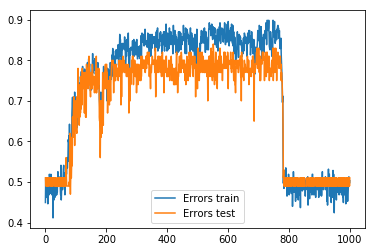

Learning rate: 1
[0.58999999999999997, 0.51000000000000001, 0.51000000000000001, 0.56000000000000005, 0.83999999999999997] [0.49939999999999996, 0.4993285714285714, 0.49918571428571423, 0.49914285714285711, 0.69510000000000005]


In [67]:
dropout_rate=0.8
weight_decay=0
for learning_rate in [0.00001,0.0001,0.001,0.01,0.1,1]:
    net_type=ThreeLayersParams
    optimizer_type=optim.Adam
    criterion_type=nn.CrossEntropyLoss
    network_params=NetworkParams(linear_filters=[200,2],dropout_rate=dropout_rate)
    optimizer_params=OptimizerParams(weight_decay=weight_decay,learning_rate=learning_rate)
    train_params=TrainParams(max_epoch=1000)


    params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
                  optimizer_params=optimizer_params,train_params=train_params)

    train=Train()
    epochs,errors_max,errors_mean=train(params)
    print('Learning rate:',learning_rate)
    print(errors_max,errors_mean)

### Weights initialization

  0%|          | 1/1000 [00:00<01:45,  9.47it/s]

28
Repetition 0


100%|██████████| 1000/1000 [01:48<00:00,  9.19it/s]


Performance: 0.7579


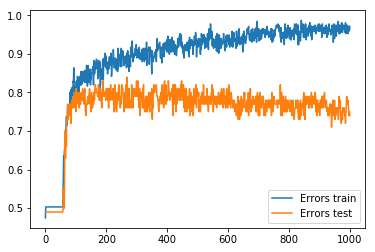

  0%|          | 1/1000 [00:00<03:11,  5.22it/s]

Repetition 1


100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


Performance: 0.49


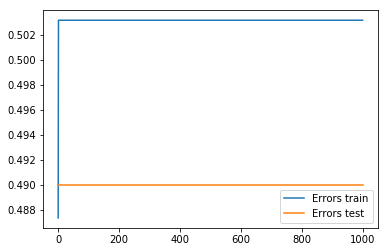

  0%|          | 1/1000 [00:00<02:22,  7.02it/s]

Repetition 2


100%|██████████| 1000/1000 [02:35<00:00,  6.44it/s]


Performance: 0.49


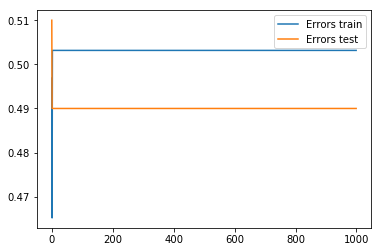

  0%|          | 1/1000 [00:00<03:06,  5.35it/s]

Repetition 3


100%|██████████| 1000/1000 [02:40<00:00,  6.24it/s]


Performance: 0.49


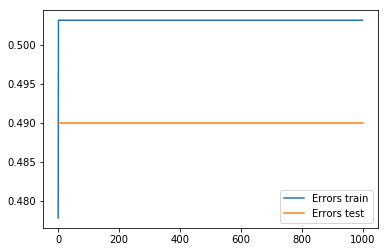

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 1000/1000 [02:43<00:00,  6.12it/s]


Performance: 0.49


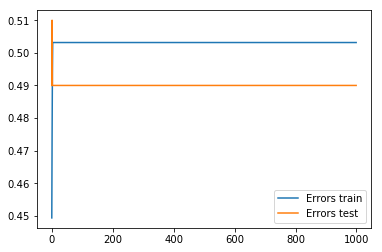

  0%|          | 0/1000 [00:00<?, ?it/s]

weights_initialization: 0.0001
[0.83999999999999997, 0.48999999999999999, 0.51000000000000001, 0.48999999999999999, 0.51000000000000001] [0.7747857142857143, 0.49000000000000016, 0.49000000000000016, 0.49000000000000016, 0.49000000000000016]
28
Repetition 0


100%|██████████| 1000/1000 [01:37<00:00, 10.24it/s]


Performance: 0.7593


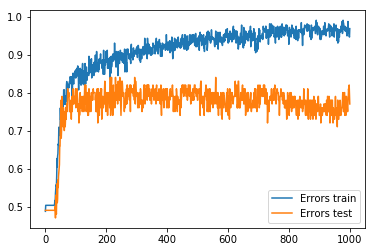

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 1000/1000 [02:01<00:00,  8.24it/s]


Performance: 0.49


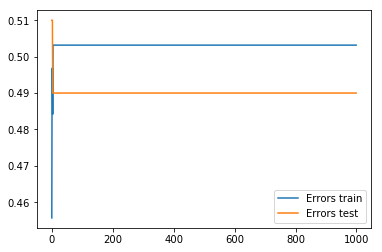

  0%|          | 1/1000 [00:00<01:51,  8.93it/s]

Repetition 2


100%|██████████| 1000/1000 [02:21<00:00,  7.08it/s]


Performance: 0.49


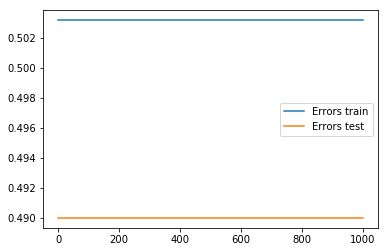

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 1000/1000 [02:33<00:00,  6.50it/s]


Performance: 0.49


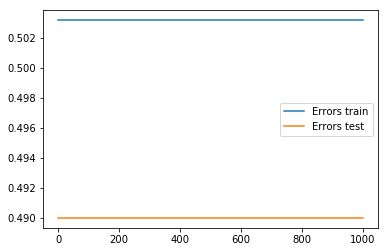

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 1000/1000 [02:34<00:00,  6.46it/s]


Performance: 0.49


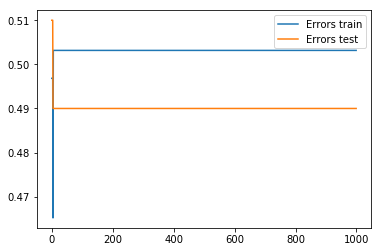

  0%|          | 0/1000 [00:00<?, ?it/s]

weights_initialization: 0.001
[0.83999999999999997, 0.51000000000000001, 0.48999999999999999, 0.48999999999999999, 0.51000000000000001] [0.7800285714285714, 0.49000000000000016, 0.49000000000000016, 0.49000000000000016, 0.49000000000000016]
28
Repetition 0


100%|██████████| 1000/1000 [01:37<00:00, 10.23it/s]


Performance: 0.7631


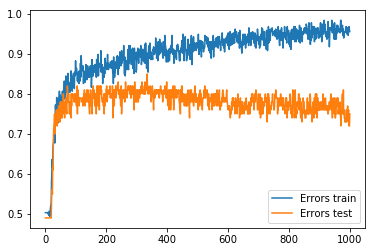

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 1000/1000 [01:37<00:00, 10.24it/s]


Performance: 0.7912


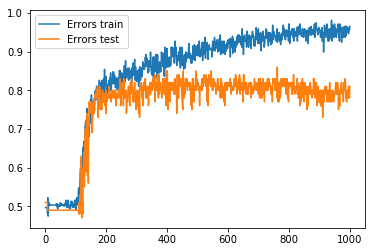

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 1000/1000 [01:37<00:00, 10.20it/s]


Performance: 0.7925


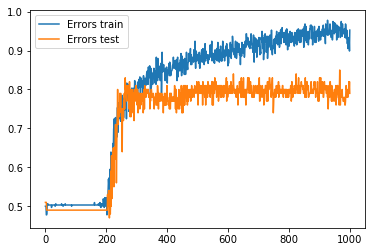

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 1000/1000 [01:39<00:00, 10.06it/s]


Performance: 0.7622


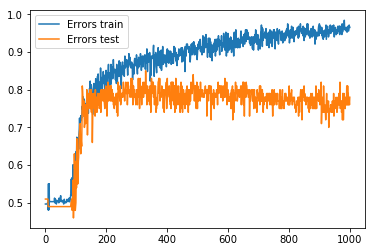

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 1000/1000 [01:46<00:00,  9.39it/s]


Performance: 0.7719


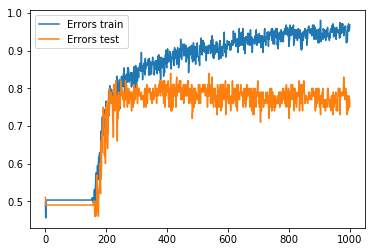

  0%|          | 0/1000 [00:00<?, ?it/s]

weights_initialization: 0.01
[0.84999999999999998, 0.85999999999999999, 0.84999999999999998, 0.84999999999999998, 0.83999999999999997] [0.78027142857142862, 0.80477142857142858, 0.79231428571428575, 0.78068571428571432, 0.78058571428571422]
28
Repetition 0


100%|██████████| 1000/1000 [01:40<00:00,  9.91it/s]


Performance: 0.7682


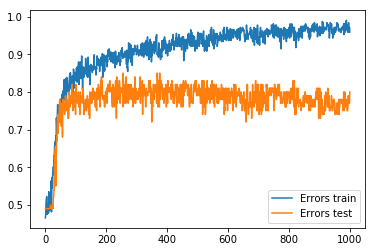

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 1000/1000 [01:39<00:00, 10.00it/s]


Performance: 0.7844


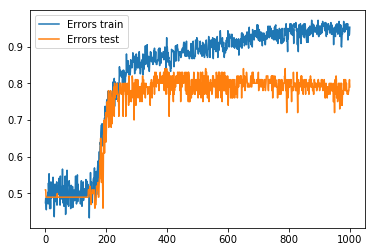

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 1000/1000 [01:39<00:00, 10.10it/s]


Performance: 0.779


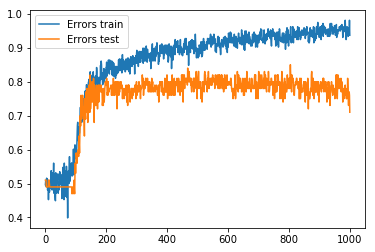

  0%|          | 1/1000 [00:00<01:45,  9.50it/s]

Repetition 3


100%|██████████| 1000/1000 [01:43<00:00,  9.62it/s]


Performance: 0.7877


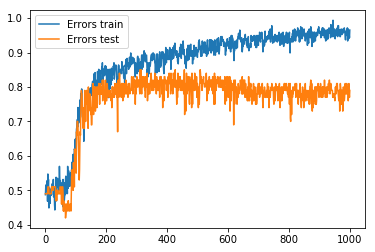

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 1000/1000 [01:39<00:00, 10.05it/s]


Performance: 0.7363


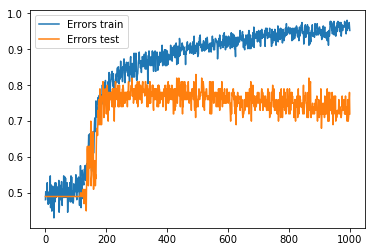

  0%|          | 0/1000 [00:00<?, ?it/s]

weights_initialization: 0.02
[0.84999999999999998, 0.83999999999999997, 0.84999999999999998, 0.84999999999999998, 0.82999999999999996] [0.78775714285714293, 0.79572857142857156, 0.78822857142857139, 0.79382857142857155, 0.75782857142857141]
28
Repetition 0


100%|██████████| 1000/1000 [01:42<00:00,  9.78it/s]


Performance: 0.7826


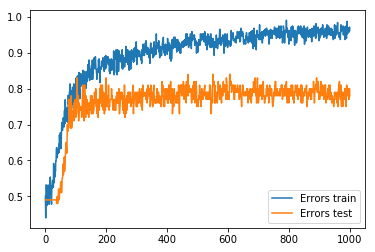

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 1000/1000 [01:40<00:00,  9.95it/s]


Performance: 0.7835


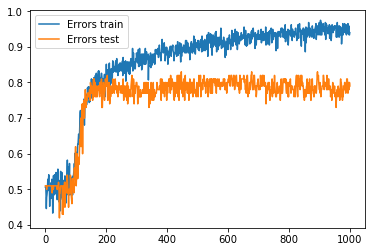

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 1000/1000 [01:40<00:00,  9.96it/s]


Performance: 0.7717


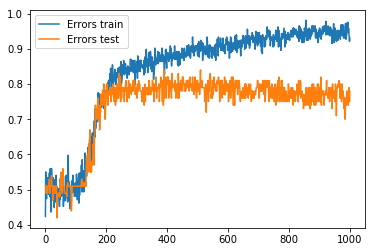

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 1000/1000 [01:39<00:00, 10.02it/s]


Performance: 0.7658


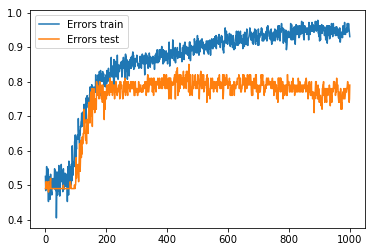

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 1000/1000 [01:39<00:00, 10.04it/s]


Performance: 0.7802


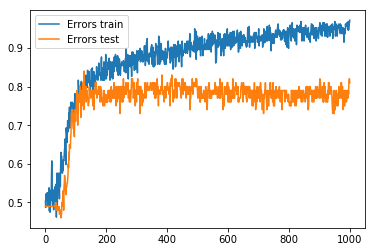

weights_initialization: 0.05
[0.83999999999999997, 0.82999999999999996, 0.83999999999999997, 0.84999999999999998, 0.83999999999999997] [0.78661428571428582, 0.78817142857142863, 0.78210000000000002, 0.78687142857142867, 0.78359999999999996]
28
Repetition

  0%|          | 1/1000 [00:00<01:49,  9.16it/s]

 0


100%|██████████| 1000/1000 [01:45<00:00,  9.47it/s]


Performance: 0.7599


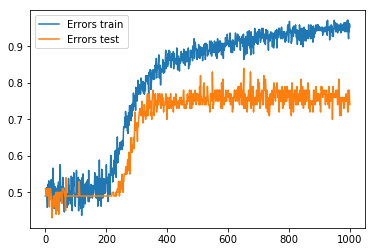

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 1000/1000 [01:44<00:00,  9.58it/s]


Performance: 0.7718


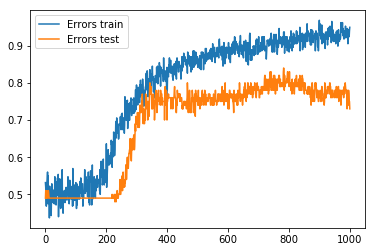

  0%|          | 1/1000 [00:00<01:49,  9.09it/s]

Repetition 2


100%|██████████| 1000/1000 [01:46<00:00,  9.41it/s]


Performance: 0.7768


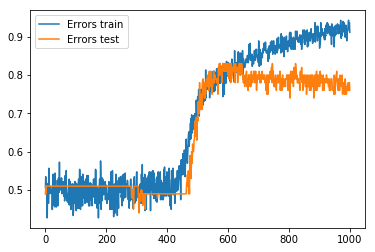

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 3


100%|██████████| 1000/1000 [01:46<00:00,  9.40it/s]


Performance: 0.7749


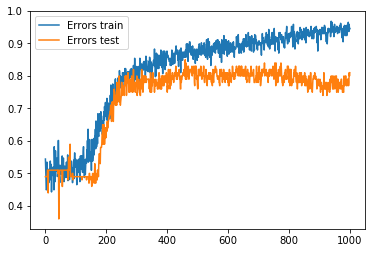

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 4


100%|██████████| 1000/1000 [01:42<00:00,  9.76it/s]


Performance: 0.7595


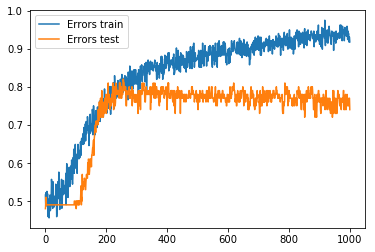

weights_initialization: 0.1
[0.83999999999999997, 0.83999999999999997, 0.82999999999999996, 0.84999999999999998, 0.81999999999999995] [0.75532857142857146, 0.76812857142857149, 0.70718571428571431, 0.79385714285714293, 0.77304285714285714]


In [69]:
dropout_rate=0.8
weight_decay=0
learning_rate=0.001

for weights_initialization in [0.0001,0.001,0.01,0.02,0.05,0.1]:
    net_type=ThreeLayersParams
    optimizer_type=optim.Adam
    criterion_type=nn.CrossEntropyLoss
    network_params=NetworkParams(linear_filters=[200,2],dropout_rate=dropout_rate)
    optimizer_params=OptimizerParams(weight_decay=weight_decay,learning_rate=learning_rate)
    train_params=TrainParams(max_epoch=1000,weights_initialization=weights_initialization)


    params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
                  optimizer_params=optimizer_params,train_params=train_params)

    train=Train()
    epochs,errors_max,errors_mean=train(params)
    print('weights_initialization:',weights_initialization)
    print(errors_max,errors_mean)